In [13]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
sns.set(style='ticks',font_scale=1.2)

import cvxpy as cp
from scipy.integrate import quad, dblquad
from scipy.special import erfc, erfinv
from scipy.optimize import root

# Perfect teacher-probe overlap

The solution is given by the following saddle point equations,

\begin{equation}
R=\frac{2\alpha}{f\sqrt{2\pi}\sqrt{1-R^{2}}}\int_{-\infty}^{\kappa}Dt\ \exp\bigg(-\frac{R^{2}t^{2}}{2(1-R^{2})}\bigg)\bigg[1-\exp\bigg(-\frac{\gamma(\gamma-2Rt)}{2(1-R^{2})}\bigg)\bigg](\kappa-t)
\end{equation}

\begin{equation}
1-R^{2}=\frac{2\alpha}{f}\int_{-\infty}^{\kappa}Dt\ \bigg[H\bigg(-\frac{Rt}{\sqrt{1-R^{2}}}\bigg)-H\bigg(-\frac{Rt-\gamma}{\sqrt{1-R^{2}}}\bigg)\bigg](\kappa-t)^{2}
\end{equation}

In [14]:
def H(x):
    return 1/2*erfc(x/np.sqrt(2))

def solve_perceptron(X,y):
    N = X.shape[0]

    # Convex optimization
    w_var = cp.Variable(N)
    yhat = w_var@X
    loss = cp.sum(cp.pos(-cp.multiply(yhat,y)))
    prob = cp.Problem(
            cp.Minimize(cp.norm2(w_var)),
            [cp.multiply(y,yhat) >= 1]
    )
    prob.solve()
    w = w_var.value
    print("Solver status:", prob.status)
    print("Solver stats:", prob.solver_stats.__dict__)
    # compute_time = prob.solver_stats.setup_time + prob.solver_stats.solve_time
    # Safely extract timing info (handle None)
    try:
        setup = prob.solver_stats.setup_time or 0.0
        solve = prob.solver_stats.solve_time or 0.0
        compute_time = setup + solve
    except:
        compute_time = 0.0

    return w, compute_time

In [15]:
def intg1(t,k,R,kthresh):
    measure = np.exp(-t**2/(2*(1-R**2)))*(np.exp(kthresh*(2*R*t-kthresh)/(2*(1-R**2)))-1)/(2*np.pi)
    integrand = (t-k)/f
    return measure*integrand

def intg2(t,k,R,kthresh):
    measure = np.exp(-t**2/2)/np.sqrt(2*np.pi)*(1-H((kthresh-R*t)/np.sqrt(1-R**2))-H(R*t/np.sqrt(1-R**2)))
    integrand = (k-t)**2/f
    return measure*integrand

def eq1(k,R,alpha,kthresh):
    intg,tol = quad(intg1,-np.inf,k,args=(k,R,kthresh))
    rhs = 2*alpha*intg/np.sqrt(1-R**2)
    lhs = R
    return rhs - lhs

def eq2(k,R,alpha,kthresh):
    intg,tol = quad(intg2,-np.inf,k,args=(k,R,kthresh))
    rhs = 2*alpha*intg
    lhs = 1-R**2
    return rhs - lhs

def eq(args,alpha,kthresh):
    k,R = args
    return eq1(k,R,alpha,kthresh)**2 + eq2(k,R,alpha,kthresh)**2

def eq_root(args,alpha,kthresh):
    k,R = args
    if 1e-10<R<1-1e-10:
      return eq1(k,R,alpha,kthresh), eq2(k,R,alpha,kthresh)
    elif R<=1e-10:
      return -R**2,-R**2
    else:
      return R**2,R**2

In [16]:
Rs = []
Rtheory = []
times_all = []
fs = np.logspace(-1,0,10)
# fs = np.linspace(0.1,1,10)
navg = 100
alphas = np.logspace(0.1,0.5,30)
for alpha in tqdm(alphas):
  for f in fs:
    kthresh = erfinv(f)*np.sqrt(2)
    Rtmp = []
    ktmp = []
    for _ in range(navg):
      N = 200
      P = int(alpha*N)
      X = np.random.randn(N,P)/np.sqrt(N)

      # Prune
      a = np.random.randn(100000)/np.sqrt(N)
      X[0] = a[np.abs(a)<kthresh/np.sqrt(N)][:P]
#             prune_idxs = np.where(np.abs(X[0])<kthresh/np.sqrt(N))[0]
#             Xprune = X[:,prune_idxs]
      w_teacher = np.zeros(N)
      w_teacher[0] = 1
      y = np.sign(w_teacher@X)
      w_student,compute_time = solve_perceptron(X,y)
      R = np.corrcoef([w_student,w_teacher])[0,1]
      k = np.sqrt(N)/np.linalg.norm(w_student)
      Rtmp.append(R)
      ktmp.append(k)
      times_all.append(compute_time)
    Rs.append(np.mean(Rtmp))

    # Theory
    out = root(eq_root,(np.mean(ktmp),np.mean(Rtmp)),args=(alpha,kthresh))
    if out.success:
      k,R = out.x
    else:
      R = np.nan
    Rtheory.append(R)
Rs = np.stack(Rs).reshape(len(alphas),len(fs))
Rtheory = np.stack(Rtheory).reshape(len(alphas),len(fs))
times_all = np.stack(times_all).reshape(len(alphas),len(fs),navg)

  0%|          | 0/30 [00:00<?, ?it/s]

Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.229424706, 'setup_time': None, 'num_iters': 16, 'extra_stats': None}
Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.201879206, 'setup_time': None, 'num_iters': 13, 'extra_stats': None}
Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.17524646, 'setup_time': None, 'num_iters': 13, 'extra_stats': None}
Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.231002248, 'setup_time': None, 'num_iters': 15, 'extra_stats': None}
Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.217121044, 'setup_time': None, 'num_iters': 17, 'extra_stats': None}
Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.235148918, 'setup_time': None, 'num_iters': 16, 'extra_stats': None}
Solver status: optimal
Solver stats: {'solver_name': 'CLARABEL', 'solve_time': 0.193564334, 'setup_ti

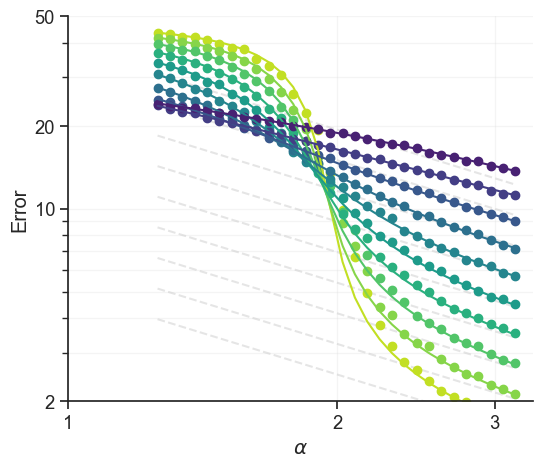

In [17]:
# plt.axvline(np.sqrt(N)/2)
with sns.color_palette('viridis_r', len(fs)):
  plt.figure(figsize=(6,5))
  for i in range(len(fs)):
      plt.scatter(alphas,100*np.arccos(Rs[:,i])/np.pi,label=str(int(np.round(100*fs[i])))+'%')
      plt.plot(alphas[Rtheory[:,i]>0],100*np.arccos(Rtheory[:,i][Rtheory[:,i]>0])/np.pi)
      if i<len(fs)-1:
          plt.plot(alphas,100*0.5*fs[i]/alphas,linestyle='dashed',c='grey',alpha=0.2,zorder=-99)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel(r'$\alpha$')
# plt.legend();
plt.xticks([1,2,3],[1,2,3])
plt.yticks([2,10,20,50],[2,10,20,50])
plt.ylim([2,50])
plt.grid(True,which='both',alpha=0.2)
sns.despine()
# from google.colab import files
# plt.savefig("perceptron_pruning.pdf",transparent='True')
# files.download("perceptron_pruning.pdf")